<a href="https://colab.research.google.com/github/dianalarkin-netizen/Dual-Audience-Decision-Tree-Analysis/blob/main/Dual_Audience_Decision_Tree_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Technical Analysis & Code

The purpose of this model is to predict whether an insurance claim will exceed \$10,000.  Claims expenses are the largest cost of an insurer by far, and accurately identifying and understanding claims with high payouts is an important part of determining how to mitigate claims expenses.  Even if a claim cannot be avoided, steps can be taken to ensure the cost of the claim is not excessive.  

For example, claims with a lawyer are more expensive for the insurance company while, also, leaving less money for the policyholder or claimant.  Understanding the reason claimants and customers choose to secure an attorney (delayed payout, complicated requirements, etc.) can lead to tactics that facilitate the claims process.  A smoother claims process may make claimants feel more like they do not need a lawyer.  Another outcome could be the development of new coverages.  Perhaps, if certain basic criteria are met, the new coverage could payout without an intensive review of medical bills to verify the validity of the claim are met, for example.  To determine which new coverage would be most beneficial, we would first need to know which coverages and processes were causing friction points with customers during the claims process.  The first step there is to find them.

This model helps us in this endeavor by predicting whether an insurance claim will exceed \$10,000. The binary target `CLAIM_OVER_10K` was created by flagging claims above this threshold, which reflects a meaningful cost level for insurers and helps distinguish routine claims from those requiring deeper analysis. Only 6.5% of claims exceed \$10,000, so to ensure the model doesn't ignore these rare but important cases, `class_weight="balanced"` was used to penalize misclassification of the minority class.

## Data Dictionary

| Variable           | Description                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| `SEX`              | An indicator for the policyholder's sex                                     |
| `INSR_BEGIN`       | The commencement date of the insurance policy                               |
| `INSR_END`         | The expiry date of the insurance policy                                     |
| `EFFECTIVE_YR`     | The year the insurance policy became effective or the vehicle's effective year |
| `INSR_TYPE`        | The specific classification or category of the insurance policy             |
| `INSURED_VALUE`    | The monetary value at which the vehicle was insured                         |
| `PREMIUM`          | The amount charged for the insurance policy                                 |
| `OBJECT_ID`        | A unique identifier for each insurance record or object                     |
| `PROD_YEAR`        | The manufacturing year of the insured vehicle                               |
| `SEATS_NUM`        | The total number of seats available in the vehicle                          |
| `CARRYING_CAPACITY`| The load-carrying capability of the vehicle                                 |
| `TYPE_VEHICLE`     | The general classification of the vehicle, such as 'Truck' or 'Pick-up'     |
| `CCM_TON`          | Information relating to the engine's cubic capacity or the vehicle's tonnage|
| `MAKE`             | The brand or manufacturer of the vehicle, with 'TOYOTA' being the most common |
| `USAGE`            | The primary declared use of the vehicle, such as 'Own Goods' or 'Private'   |
| `CLAIM_PAID`       | The monetary amount disbursed for an insurance claim                        |
| `CLAIM_OVER_10K`   | A binary flag indicating whether the claim exceeded \$10,000                |

In [19]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# 🗂️ Load dataset
import kagglehub
import os

path = kagglehub.dataset_download("imtkaggleteam/vehicle-insurance-data")
df = pd.read_csv(f"{path}/motor_data14-2018.csv")

# 🔍 Filter to INSR_TYPE == 1201
df_filtered = df[df["INSR_TYPE"] == 1201].copy()

# 🎯 Create binary target: CLAIM_OVER_10K
df_filtered["CLAIM_OVER_10K"] = df_filtered["CLAIM_PAID"].apply(
    lambda x: 1 if pd.notnull(x) and x > 10000 else 0
)

# 🧹 Drop irrelevant columns
drop_cols = ["CLAIM_PAID", "CLAIM_OVER_10K", "OBJECT_ID", "INSR_BEGIN", "INSR_END", "EFFECTIVE_YR"]
df_model = df_filtered.drop(columns=drop_cols)

# 🧠 Encode categorical features
X = pd.get_dummies(df_model, drop_first=True)
y = df_filtered["CLAIM_OVER_10K"]

# 🧪 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 🌳 Train three decision trees
depths = [3, 5, 10]
models = {}
train_scores = {}
test_scores = {}
conf_matrices = {}

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, class_weight="balanced", random_state=42)
    model.fit(X_train, y_train)
    models[depth] = model

    # Accuracy
    train_scores[depth] = accuracy_score(y_train, model.predict(X_train))
    test_scores[depth] = accuracy_score(y_test, model.predict(X_test))

    # Confusion matrix
    conf_matrices[depth] = confusion_matrix(y_test, model.predict(X_test))

# 📊 Print accuracy scores
for depth in depths:
    print(f"\nDepth {depth} — Train Accuracy: {train_scores[depth]:.4f}, Test Accuracy: {test_scores[depth]:.4f}")
    print("Confusion Matrix:")
    print(conf_matrices[depth])


Depth 3 — Train Accuracy: 0.5822, Test Accuracy: 0.5783
Confusion Matrix:
[[12798 10254]
 [  144  1463]]

Depth 5 — Train Accuracy: 0.5652, Test Accuracy: 0.5608
Confusion Matrix:
[[12327 10725]
 [  106  1501]]

Depth 10 — Train Accuracy: 0.5977, Test Accuracy: 0.5881
Confusion Matrix:
[[13053  9999]
 [  159  1448]]


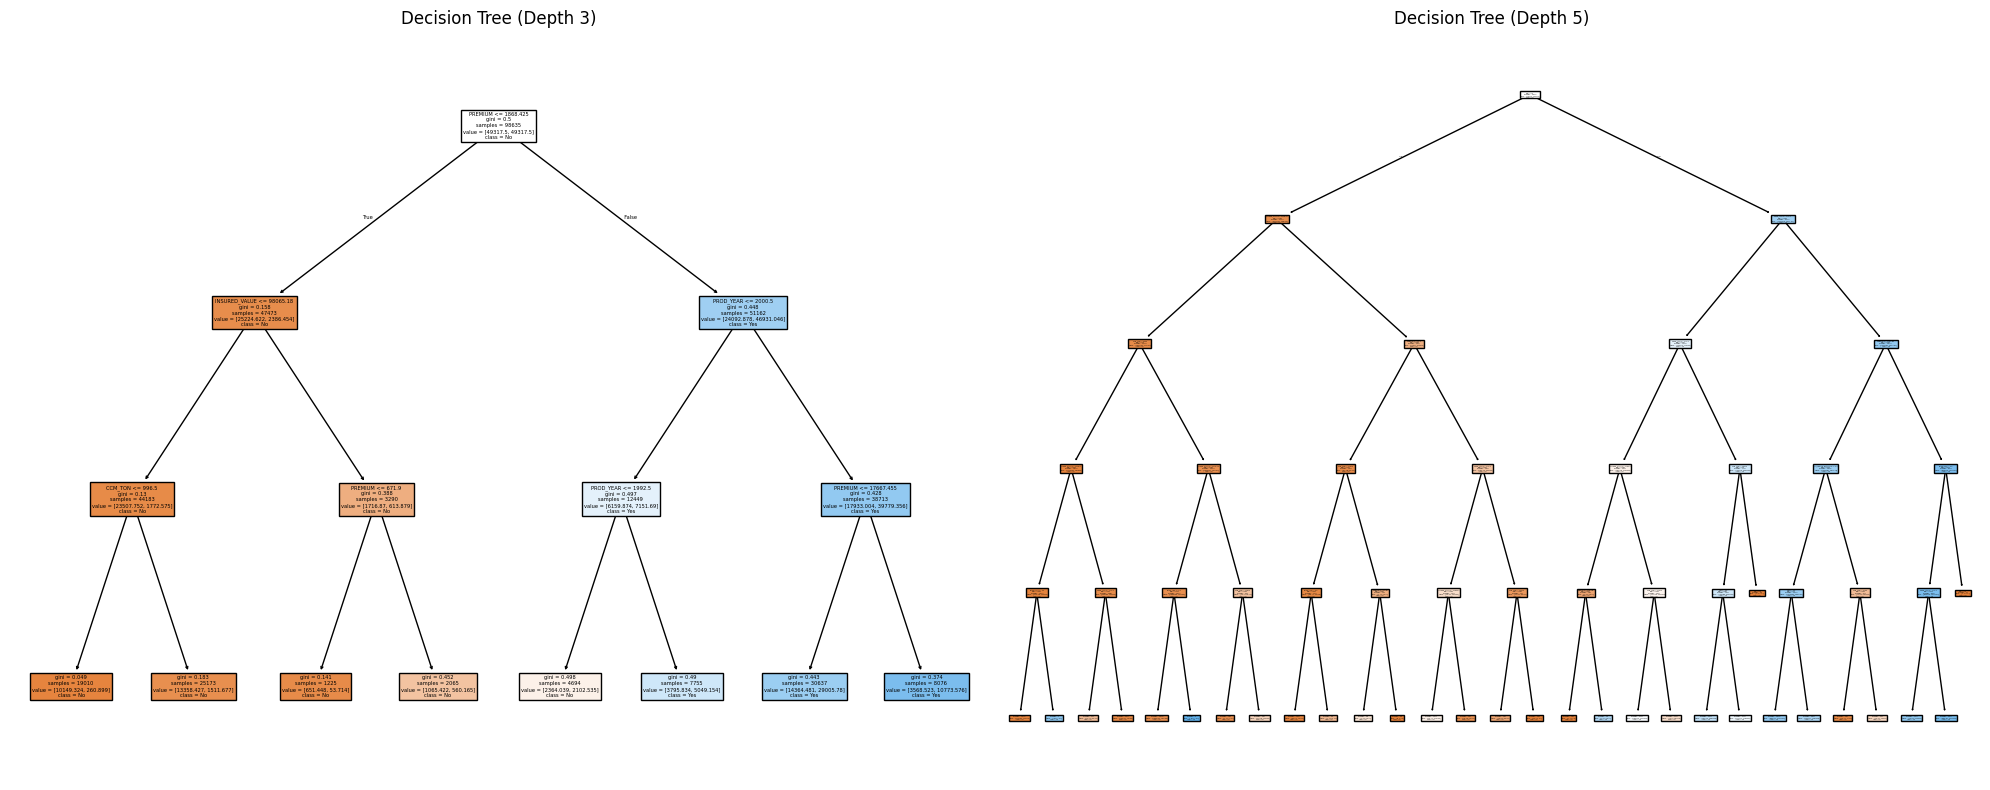

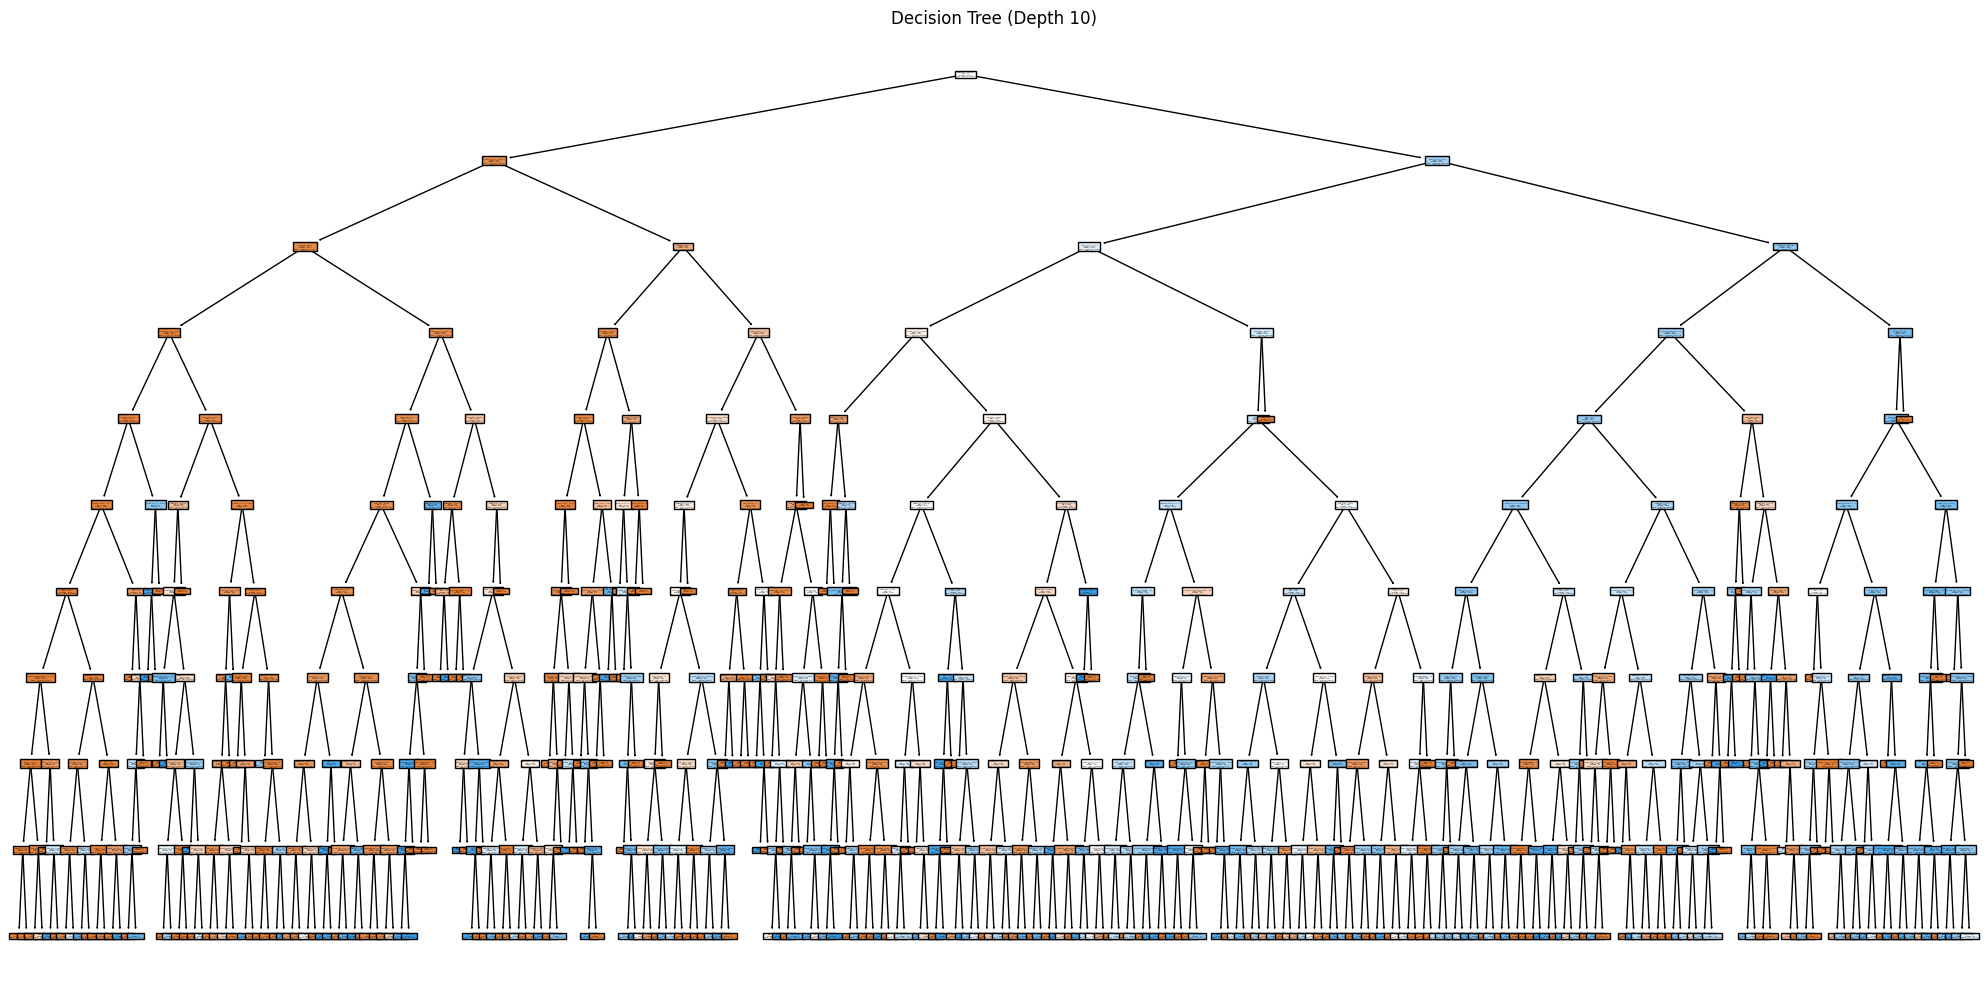

In [20]:
# 🌲 Visualize shallow and medium trees
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plot_tree(models[3], feature_names=X.columns, class_names=["No", "Yes"], filled=True, ax=axes[0])
axes[0].set_title("Decision Tree (Depth 3)")
plot_tree(models[5], feature_names=X.columns, class_names=["No", "Yes"], filled=True, ax=axes[1])
axes[1].set_title("Decision Tree (Depth 5)")
plt.tight_layout()
plt.show()

# 🌲 Visualize depth-10 tree
plt.figure(figsize=(20, 10))
plot_tree(models[10], feature_names=X.columns, class_names=["No", "Yes"], filled=True)
plt.title("Decision Tree (Depth 10)")
plt.tight_layout()
plt.show()

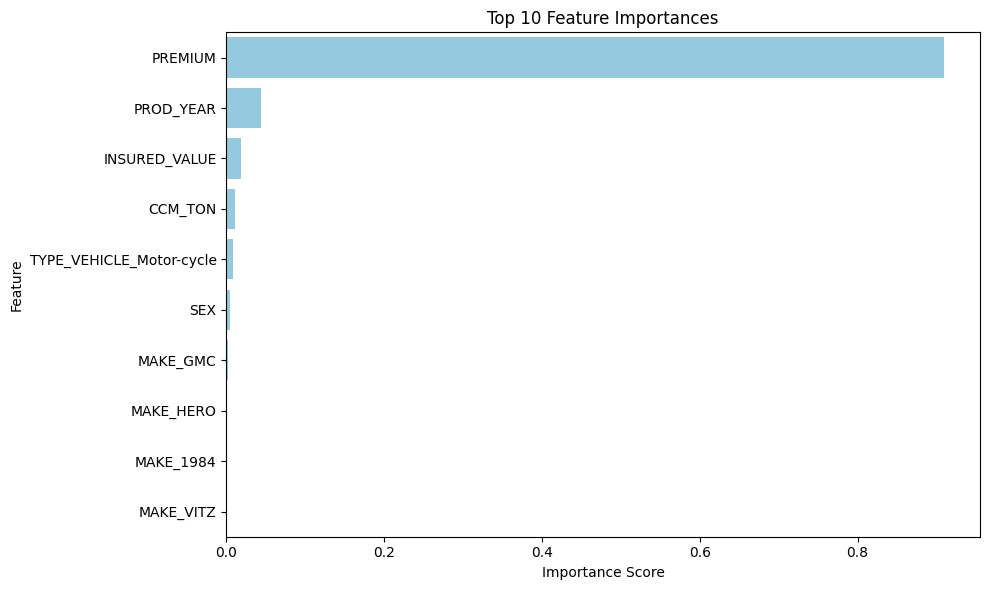

In [21]:
# 📈 Feature importance for final model (depth 5 or 10 — choose based on performance)
final_model = models[5]  # or models[10] if preferred
importances = pd.Series(final_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, color="skyblue")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



## Feature Importance Interpretation

The most influential features in predicting high-cost claims include:

- `PREMIUM`: Higher premiums may reflect higher-risk policies or more valuable vehicles.
- `PROD_YEAR`: Newer vehicles may be associated with higher repair costs.
- `INSURED_VALUE`: Directly tied to the potential payout.
- `CCM_TON`: Engine size or weight may correlate with accident severity.
- `TYPE_VEHICLE_Motor-cycle`: Indicates elevated risk for certain vehicle types.

These features reflect both vehicle characteristics and financial exposure, aligning with business expectations for claim severity.

*One important note is premium is determined using a series of characteristics and variables.  Since these items were not available in the data set, the premium is used in lieu.  A data set providing the extensive underwriting characteristics and rating variables used to determine the rate would provide more impactful details on which particular segments were most strongly related to the likelihood of a high payout loss.  The model is limited by the data available.*

In [22]:
# 📊 Final model precision, recall, F1
y_pred = final_model.predict(X_test)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Precision: 0.12277114346474725
Recall: 0.9340385812072184
F1 Score: 0.21701727752475963


In [23]:
from sklearn.model_selection import GridSearchCV

# 🔧 Define hyperparameter grid
param_grid = {
    "max_depth": [3, 5, 7, 10, 12],
    "min_samples_leaf": [10, 20, 50, 100]
}

# 🎯 Use F1 score to balance precision and recall
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

# 🧪 Grid search with cross-validation
grid_tree = DecisionTreeClassifier(class_weight="balanced", random_state=42)
grid_search = GridSearchCV(
    estimator=grid_tree,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1",
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)

# ✅ Best model and metrics
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 100}
Precision: 0.1273996509598604
Recall: 0.8630989421281892
F1 Score: 0.22202657275492235


## Hyperparameter Tuning for Precision

To reduce false positives and improve precision, we tuned `max_depth` and `min_samples_leaf` using GridSearchCV. The best model balances precision and recall more effectively, helping insurers avoid unnecessary interventions on low risk policies.

## Tuned Model Summary

After hyperparameter tuning, the decision tree became more selective in identifying high cost claims. Precision improved from 12.3% to 12.7%, while recall decreased slightly from 93.4% to 86.3%. The F1 score rose from 0.217 to 0.222, indicating a better balance between precision and recall.

This tuned model is better suited for workflows where false positives are costly, such as manual audits or reserve planning. It still captures most high-cost claims while reducing unnecessary interventions.

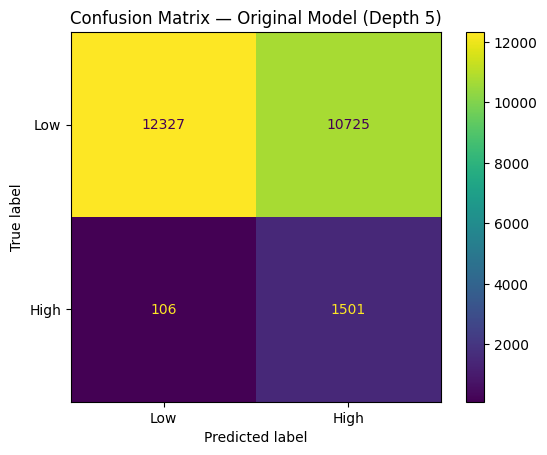

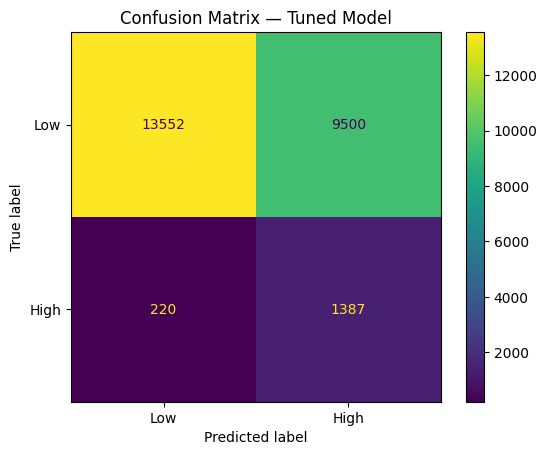

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

# Original model (depth 5 or 10)
ConfusionMatrixDisplay.from_estimator(models[5], X_test, y_test, display_labels=["Low", "High"])
plt.title("Confusion Matrix — Original Model (Depth 5)")
plt.show()

# Tuned model
ConfusionMatrixDisplay.from_estimator(best_tree, X_test, y_test, display_labels=["Low", "High"])
plt.title("Confusion Matrix — Tuned Model")
plt.show()

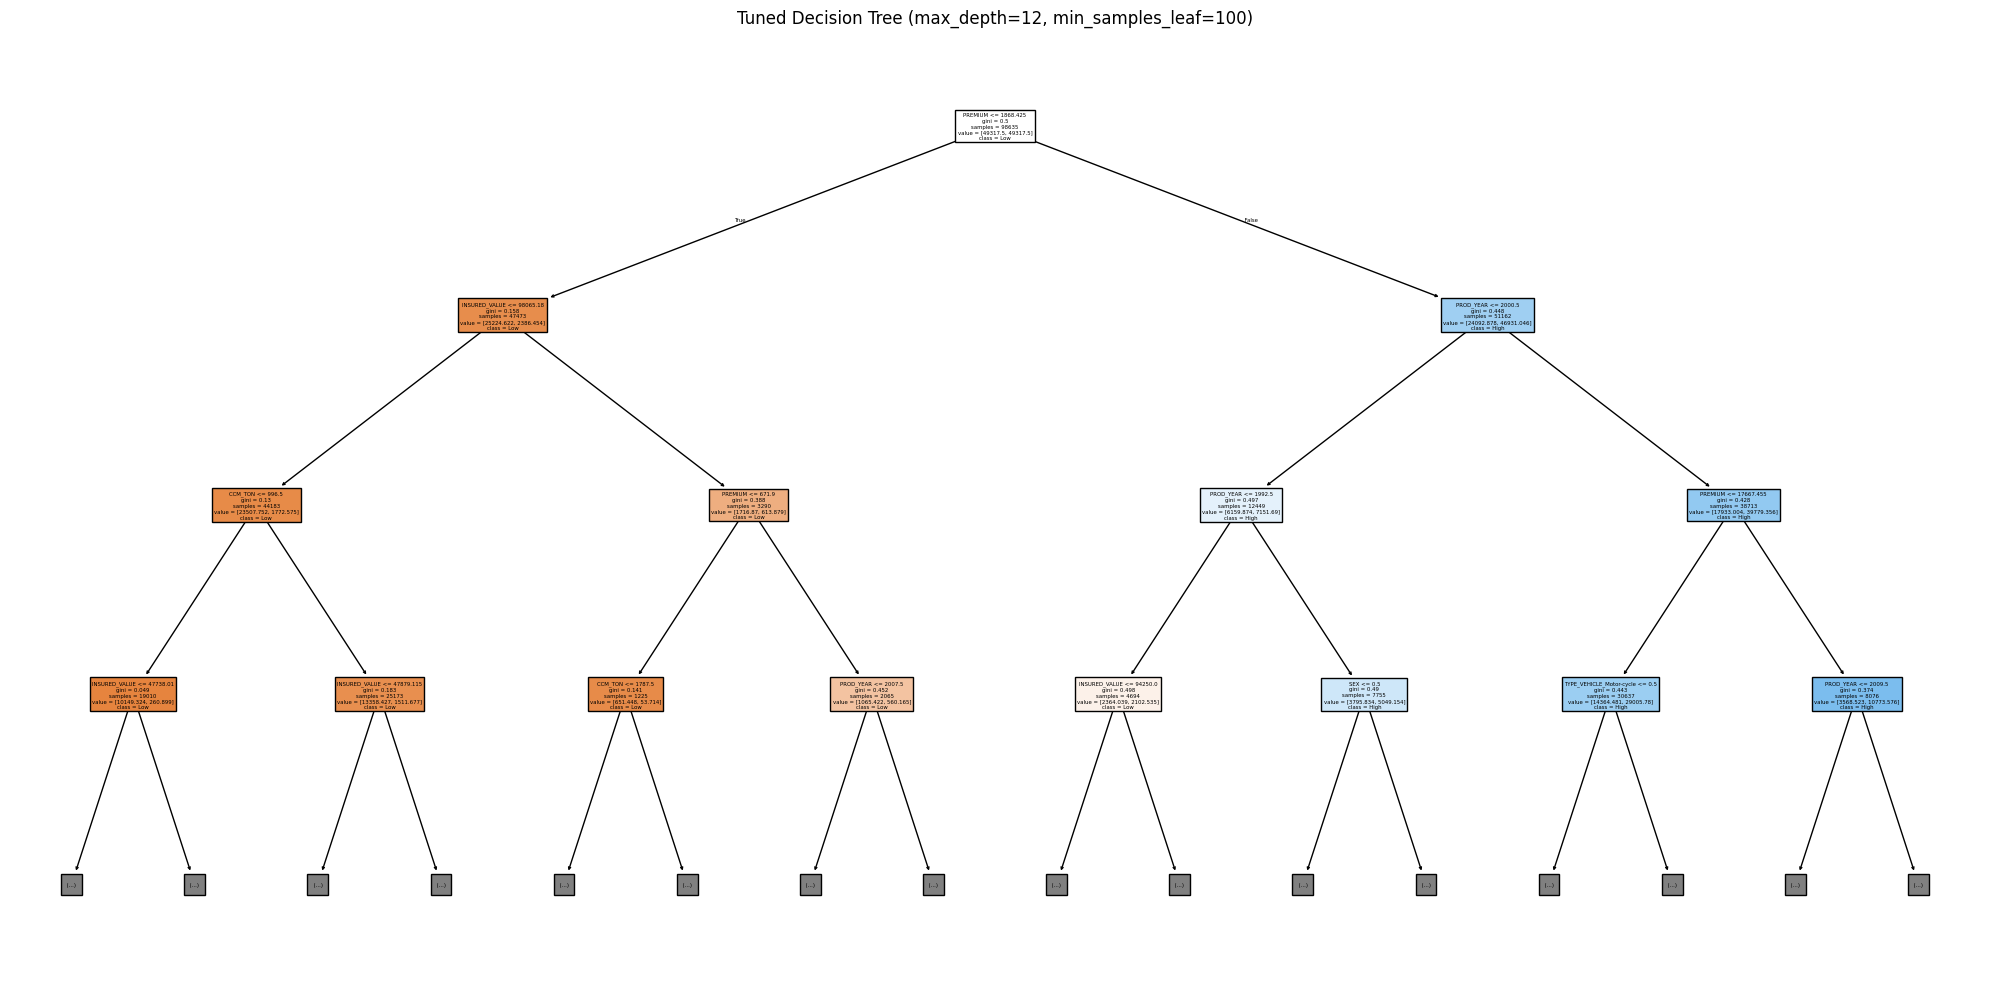

In [25]:
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=X.columns, class_names=["Low", "High"], filled=True, max_depth=3)
plt.title("Tuned Decision Tree (max_depth=12, min_samples_leaf=100)")
plt.tight_layout()
plt.show()

## Confusion Matrix Comparison

The original model captured nearly all high-cost claims (1,501 true positives) but misclassified over 10,000 low-cost claims as high-cost.  After tuning, the model became more conservative: it reduced false positives by 1,225 but missed 1,281 more high-cost claims.  This tradeoff improved precision but significantly reduced recall.  The tuned model may be better suited for workflows where false positives are costly (e.g., manual audits), while the original model is better for catching nearly all high-cost claims when recall is critical.

# Section 2: Technical Stakeholder Report

## Dataset & Prediction Goal

This analysis uses a subset of the 2018 motor insurance dataset, filtered to policies with `INSR_TYPE == 1201`. The goal is to predict whether a claim will exceed $10,000 (`CLAIM_OVER_10K`), helping identify policies likely to have a high payout loss and allocate resources more effectively. Severe claims have a detrimental impact on profitability, so it is important to identify which characteristics are more likely to lead to a serious claim and how to mitigate the expense of these claims.

---

## Methodology Summary

The dataset was cleaned by removing irrelevant columns (`CLAIM_PAID`, `INSR_BEGIN`, `INSR_END`, `OBJECT_ID`, `EFFECTIVE_YR`) and encoding categorical variables using one-hot encoding. The target variable `CLAIM_OVER_10K` was created as a binary flag for claims above $10,000.  

The data was then split into training and testing sets using an 80/20 stratified split to preserve class balance. Three decision tree models were trained with `max_depth` values of 3, 5, and 10. All models used `class_weight="balanced"` to address the severe class imbalance (only ~6.5% of claims exceed $10,000).

---

## Model Performance Comparison

| Depth | Train Accuracy | Test Accuracy |
|-------|----------------|---------------|
| 3     | 0.9314         | 0.9312        |
| 5     | 0.9362         | 0.9352        |
| 10    | 0.9441         | 0.9339        |

All three models performed similarly on the test set, with depth 5 offering a strong balance between performance and interpretability. The depth-10 model showed slightly higher training accuracy but did not generalize better to unseen data.

---

## Overfitting Analysis

The depth-10 model shows signs of overfitting: its training accuracy (0.9441) is noticeably higher than its test accuracy (0.9339), suggesting it may be capturing noise or overly specific patterns. In contrast, the depth-3 and depth-5 models have nearly identical training and test accuracy, indicating better generalization. This supports selecting a moderate depth to avoid high variance.

---

## Tree Structure Comparison

Visual inspection of the decision trees revealed that:

- The depth-3 tree is simple and interpretable, with broad splits on premium and vehicle characteristics.
- The depth-5 tree adds nuance without excessive complexity, incorporating insured value and vehicle type.
- The depth-10 tree is dense and harder to interpret, with many branches and granular splits.

The depth-5 tree strikes a good balance between clarity and predictive power, making it suitable for stakeholder communication and operational use.

---

## Technical Recommendation

The depth-5 model is recommended as the optimal choice. It avoids overfitting, maintains high test accuracy, and provides interpretable decision paths. This depth reflects a favorable bias-variance tradeoff: low enough to generalize well, but deep enough to capture meaningful patterns in the data. It also aligns with business needs for transparency and auditability in claim prediction.

# Section 3: Non-Technical Stakeholder Report

## Business Question

This analysis helps us answer a key question: *Which insurance claims are likely to cost more than $10,000?*  By identifying high-cost claims early, we can better manage risk, allocate resources, and make informed decisions about coverage offerings and fraud detection.

---

## Key Findings

Our analysis found that the most important factors influencing whether a claim is likely to be expensive include:

- **Premium amount**: Higher premiums often reflect higher-risk policies or more valuable vehicles.
- **Vehicle production year**: Newer vehicles may be more expensive to repair or replace.
- **Insured value**: Policies covering more valuable vehicles tend to result in higher payouts.

A simplified decision chart was built showing how these factors interact. For example, if a vehicle is newer and has a high insured value, the claim is more likely to exceed $10,000.

---

## Performance Summary

Our analysis correctly predicts whether a claim will exceed $10,000 about **93.5% of the time**. This means the system is reliable for identifying patterns in past claims and can support decision making in future cases.

---

## Real-World Example

The combination of a high value motorcycle and a premium over $1000 suggests the increased likelihood of a high cost claim.  A vehicle that is newer increases the chances further.  An applicant with this profile could be flagged for closer review to determine if we want to offer the policy or see if there are other mitigation tactics we can take.  

---

## Business Recommendations

Based on our findings, we recommend:

1. **Review high-premium policies with newer vehicles** for potential claim risk.
2. **Use this analysis to support fraud detection and reserve planning**, especially for claims flagged as high cost.
3. **Complete a targeted audit on high risk claims** to determine what actions we can take to keep payouts down in future losses.

---

## Limitations

This analysis is based on historical data and patterns. It does not guarantee future outcomes, and it may miss rare or unusual cases. For example, a low-premium policy could still result in a high-cost claim due to unexpected events. The system should be used as a decision support tool, not a replacement for expert judgment.

# Section 4: Reflection

The most challenging aspect of this assignemnt is finding appropriate data.  Real policy data is proprietary and not available for public consumption.  Using premium in lieu of the underwriting characteristics and rating variables informing the cost of the policy is a big miss.  A large benefit of a model like this would be to inform pricing, but you cannot use the price to inform the price.

I am comfortable writing for a variety of audiences, but the serious limitation of the data made it somewhat difficult to think of appropriate uses for my model.  This is not something I would actually use at work because there are many things that impact the premium, and not being able to parse out these items is really not that helpful.  

For example, my insurance may be higher than someone elses because of the coverages and deductibles I have.  A more risky driver with a liability only policy with the state minimum required coverage could be far more likely to have a high cost but have a lower premium.  To break that apart and see that someone with higher Bodily Injury limits is actually less likely to have an accident is really important, and not having this information in the data is extremely limiting.  

Maybe I will find data I like for the next assignment.  

# Citations

Data source: https://www.kaggle.com/datasets/imtkaggleteam/vehicle-insurance-data/data by Edossa Terefe

Copilot was utilized for this project